In [3]:
#Random Forest Model
import pandas as pd
import numpy as np
file_source='https://raw.githubusercontent.com/RaterBai/DS-Project/master/prepared%20datasets/'

In [6]:
##Load train & test datasets
train=pd.read_csv(file_source+'train.csv',dtype=str)
test=pd.read_csv(file_source+'test.csv',dtype=str)

In [15]:
print('train', train.shape)
print('test', test.shape)

train (615, 377)
test (304, 377)


In [75]:
train_x=train.iloc[:,1:376]
train_y=train.iloc[:,376]
test_x=test.iloc[:,1:376]
test_y=test.iloc[:,376]

In [79]:
from collections import Counter
Counter(train_y),Counter(test_y)

(Counter({'1': 513, '0': 102}), Counter({'1': 254, '0': 50}))

In [80]:
102/513, 50/254
#the strafied split is successful since the 0/1 ratio is similar

(0.19883040935672514, 0.1968503937007874)

In [177]:
from sklearn import tree
from sklearn import model_selection
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

In [202]:
rf=RandomForestClassifier(n_estimators = 100).fit(train_sel, train_y)
y_pred=rf.predict(test_sel)

# performance
print ("Classification report for %s" % rf)
print (metrics.classification_report(test_y, y_pred))

print("F1 micro: %1.4f\n" % f1_score(test_y, y_pred, average='micro'))
print("F1 macro: %1.4f\n" % f1_score(test_y, y_pred, average='macro'))
print("F1 weighted: %1.4f\n" % f1_score(test_y, y_pred, average='weighted'))
print("Accuracy: %1.4f" % (accuracy_score(test_y, y_pred)))


Classification report for RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.02      0.04        50
           1       0.84      1.00      0.91       254

    accuracy                           0.84       304
   macro avg       0.92      0.51      0.48       304
weighted avg       0.86      0.84      0.77       304

F1 micro: 0.8388

F1 macro: 0.4756

F1 weighted: 0.7685

Accuracy: 0.8388


In [192]:
#Feature selection
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100)).fit(train_x, train_y)
selected_feat=train_x.columns[(sel.get_support())]
train_sel=train_x.loc[:,selected_feat]
test_sel=test_x.loc[:,selected_feat]

In [214]:
selected_feat.shape

(125,)

In [215]:
# k-fold cross validation for parameter optimization: RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def k_fold_CV(clf, params, dx, dy):
    cv_model = RandomizedSearchCV(clf, params, scoring='roc_auc', n_jobs=-1, 
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=13), 
                                  verbose=1, iid=True, n_iter=100, refit=True)
    
    cv_model.fit(dx, dy)
    y_pred=cv_model.predict(test_x)
    f1=f1_score(test_y, y_pred, average='weighted')
    accuracy=accuracy_score(test_y, y_pred)
    precision=precision_score(test_y, y_pred, average='weighted')
    recall=recall_score(test_y, y_pred, average='weighted')
    matrix=confusion_matrix(test_y, y_pred)
    
    # performance
    print("F1 weighted: %1.5f\n" % f1)
    print("Accuracy: %1.5f" % accuracy)
    print("Precision weighted: %1.5f" % precision)
    print("Recall weighted: %1.5f" % recall)
    print("Confusion matrix: ", matrix)
    
    return cv_model.best_estimator_, cv_model.best_score_

In [213]:
# random forest
rf = RandomForestClassifier(random_state=13)

# define search space
tuned_parameters = {'n_estimators':[50, 100, 250,  500, 750, 1000, 1250, 1500, 2000], 
                    'criterion':['gini', 'entropy'], 
                    'max_features':['log2', 'auto', None], 
                    'min_samples_split':[2, 3, 4], 
                    'max_depth': [3, 6, 9, 12, 15, 18, 21, 24, 32, None], 
                    'min_samples_leaf':[1, 2], 
                    'max_leaf_nodes': [None, 5, 10],
                    'min_impurity_decrease':[0.1, 0.01, 0.001, 0.0001, 0.00001],
                    'bootstrap': [True, False],
                    'class_weight': [None, 'balanced', 'balanced_subsample']}


best_rf_model, best_cv_performance = k_fold_CV(rf, tuned_parameters, train_sel, train_y)
best_rf_model, best_cv_performance

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.6min finished


F1 weighted: 0.75795

Accuracy: 0.74671
Precision weighted: 0.77158
Recall weighted: 0.74671
Confusion matrix:  [[ 18  32]
 [ 45 209]]


(RandomForestClassifier(bootstrap=True, class_weight='balanced',
                        criterion='gini', max_depth=21, max_features=None,
                        max_leaf_nodes=None, min_impurity_decrease=0.01,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=3, min_weight_fraction_leaf=0.0,
                        n_estimators=50, n_jobs=None, oob_score=False,
                        random_state=13, verbose=0, warm_start=False),
 0.6676937234612987)

In [217]:
# random forest
rf = RandomForestClassifier(random_state=13)

# define search space
tuned_parameters = {'n_estimators':[50, 100, 250,  500, 750, 1000, 1250, 1500, 2000], 
                    'criterion':['gini', 'entropy'], 
                    'max_features':['log2', 'auto', None], 
                    'min_samples_split':[2, 3, 4], 
                    'max_depth': [3, 6, 9, 12, 15, 18, 21, 24, 32, None], 
                    'min_samples_leaf':[1, 2], 
                    'max_leaf_nodes': [None, 5, 10],
                    'min_impurity_decrease':[0.1, 0.01, 0.001, 0.0001, 0.00001],
                    'bootstrap': [True, False],
                    'class_weight': [None, 'balanced', 'balanced_subsample']}


best_rf_model, best_cv_performance = k_fold_CV(rf, tuned_parameters, train_x, train_y)
best_rf_model, best_cv_performance

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 12.1min finished


F1 weighted: 0.75938

Accuracy: 0.74671
Precision weighted: 0.77523
Recall weighted: 0.74671
Confusion matrix:  [[ 19  31]
 [ 46 208]]


(RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                        criterion='gini', max_depth=9, max_features=None,
                        max_leaf_nodes=10, min_impurity_decrease=1e-05,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=50, n_jobs=None, oob_score=False,
                        random_state=13, verbose=0, warm_start=False),
 0.6500717025681158)

In [222]:
# k-fold cross validation for parameter optimization: GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def k_fold_CV_new (clf, params, dx, dy):
    cv_model = GridSearchCV(clf, params, scoring='balanced_accuracy', n_jobs=-1, 
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=13), 
                            verbose=1, refit=True)
    
    cv_model.fit(dx, dy)
    y_pred=cv_model.predict(test_x)
    f1=f1_score(test_y, y_pred, average='weighted')
    accuracy=accuracy_score(test_y, y_pred)
    precision=precision_score(test_y, y_pred, average='weighted')
    recall=recall_score(test_y, y_pred, average='weighted')
    matrix=confusion_matrix(test_y, y_pred)
    
    # performance
    print("F1 weighted: %1.5f\n" % f1)
    print("Accuracy: %1.5f" % accuracy)
    print("Precision weighted: %1.5f" % precision)
    print("Recall weighted: %1.5f" % recall)
    print("Confusion matrix: ", matrix)
    
    return cv_model.best_estimator_, cv_model.best_score_

In [223]:
# random forest
rf = RandomForestClassifier(random_state=13)

# define search space
tuned_parameters = {'n_estimators':[50, 100, 250,  500, 750, 1000, 1250, 1500, 2000], 
                    'criterion':['gini', 'entropy'], 
                    'max_features':['log2', 'auto', None], 
                    'min_samples_split':[2, 3, 4], 
                    'max_depth': [3, 6, 9, 12, 15, 18, 21, 24, 32, None], 
                    'min_samples_leaf':[1, 2], 
                    'max_leaf_nodes': [None, 5, 10],
                    'min_impurity_decrease':[0.1, 0.01, 0.001, 0.0001, 0.00001],
                    'bootstrap': [True, False],
                    'class_weight': [None, 'balanced', 'balanced_subsample']}


best_rf_model, best_cv_performance = k_fold_CV_new(rf, tuned_parameters, train_x, train_y)
best_rf_model, best_cv_performance

Fitting 5 folds for each of 291600 candidates, totalling 1458000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 51.5min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

KeyboardInterrupt: 

In [ ]:
# roc_auc score and plot
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

def plot_auc_roc(fpr, tpr):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = {:0.4f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def get_Younden_idx(fpr, tpr, threshold):
    idx = np.argmax(np.abs(tpr-fpr))
    return threshold[idx]
    
def roc_auc_analysis(clf, dx, dy):
    preds = clf.predict_proba(dx) #predict: 0 or 1, predict_proba: [0.8, 0.2], predict probability for each class
    preds = list(map(lambda x: x[-1], preds))
    fpr, tpr, threshold = roc_curve(dy, preds)
    plot_auc_roc(fpr, tpr)
    print("first three predicted probabilities: ", preds[:3])
    print("roc_auc_score: ", roc_auc_score(dy, preds))
    J  = get_Younden_idx(fpr, tpr, threshold)
    print("Youden index: ", J)

    youden_preds = list(map(lambda x: 1 if x >= J else 0, preds))
    print("first three youden predicted results: ", youden_preds[:3])
    print("accuracy after apply youden index: ", accuracy_score(dy, youden_preds))
    
    if isinstance(clf, LogisticRegression):
        cof = clf.coef_.tolist()[0]
        cof_idx = list(zip(cof, range(len(cof)))) #get the coefficients
        top_5_fea = sorted(cof_idx, key=lambda x: abs(x[0]), reverse=True)[:5]
    elif isinstance(clf, RandomForestClassifier):
        fea_imp = clf.feature_importances_
        top_5_fea = sorted(list(zip(fea_imp, range(len(fea_imp)))), key=lambda x: abs(x[0]), reverse=True)[:5]
    else: # SVM
        # for SVM with RGB kernel, this is no straightforward way to get feature improtance
        # https://stats.stackexchange.com/questions/265656/is-there-a-way-to-determine-the-important-features-weight-for-an-svm-that-uses
        pass
        top_5_fea = []
    print("top 5 features: ", list(map(lambda x: (new_feature_names[x[1]], round(x[0], 4)), top_5_fea)))

In [ ]:
# RF
roc_auc_analysis(best_rf_model, test_X, test_y)

In [84]:
selected_feat= train_x.columns[(sel.get_support())]
len(selected_feat)

117

In [85]:
print(selected_feat)

Index(['gender', 'ethnicity', 'drug_1', 'drug_10', 'drug_11', 'drug_12',
       'drug_13', 'drug_15', 'drug_17', 'drug_18',
       ...
       '192367', '196471', '444285', '376703', '40490929', '444406', '434170',
       'race_Black_or_African_American', 'race_No_matching_concept',
       'race_White'],
      dtype='object', length=117)


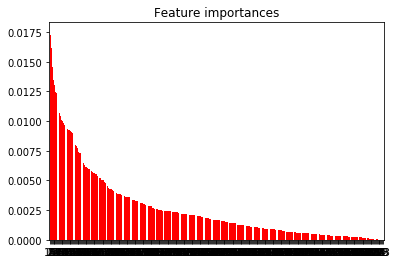

In [99]:
import matplotlib.pyplot as plt
importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
# X is the train data used to fit the model 
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_x.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(train_x.shape[1]), indices)
plt.xlim([-1, train_x.shape[1]])
plt.show()

In [190]:
"""
five-fold cross validation for parameter optimization: RandomizedSearchCV
"""
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

def five_fold_CV(clf, params, dx, dy):
    cv_model = RandomizedSearchCV(clf, params, scoring='roc_auc', n_jobs=-1, 
                                  cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=13), 
                                  verbose=1, iid=True, n_iter=100, refit=True)
    
    cv_model.fit(dx, dy)
    
    return cv_model.best_estimator_, cv_model.best_score_

SyntaxError: invalid syntax (<ipython-input-190-d7a7eaf15490>, line 14)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.7min finished


(RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                        criterion='gini', max_depth=None, max_features=None,
                        max_leaf_nodes=10, min_impurity_decrease=0.01,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=3, min_weight_fraction_leaf=0.0,
                        n_estimators=250, n_jobs=None, oob_score=False,
                        random_state=13, verbose=0, warm_start=False),
 0.6509432700250491)

In [108]:
model = RandomForestClassifier(random_state=1)
cv = cross_validate(model, train_x, train_y, cv=10)
print(cv['test_score'])
print(cv['test_score'].mean())

C:\Users\kavan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\kavan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\kavan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\kavan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\kavan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

[0.77777778 0.76190476 0.79032258 0.80327869 0.81967213 0.81967213
 0.80327869 0.73770492 0.81967213 0.75409836]
0.7887382169508028


C:\Users\kavan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
